In [39]:
# Imports
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.regression.linear_model import OLS, RegressionResults
from math import sqrt
from statsmodels.discrete.discrete_model import Logit
import warnings
warnings.filterwarnings('ignore')

#data proccessing
df = pd.read_csv('framingham_heart_disease.csv', index_col = 0)

dataset='framingham_heart_disease.csv'
df=pd.read_csv(dataset, sep=',')
df.columns.values
# removing unwanted columns
df.drop(['prevalentStroke', 'prevalentHyp','totChol','sysBP','diaBP','TenYearCHD'], axis='columns', inplace=True)
df



,male,age,education,currentSmoker,cigsPerDay,BPMeds,diabetes,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,23.10,85.0,85.0
...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,25.97,66.0,86.0
4234,1,51,3.0,1,43.0,0.0,0,19.71,65.0,68.0
4235,0,48,2.0,1,20.0,NaN,0,22.00,84.0,86.0
4236,0,44,1.0,1,15.0,0.0,0,19.16,86.0,NaN


# Part 1

The selected explanatory parameters:

* Sex - Categorical (Male / Female)

* Glucose - Numeric

* Age - Numeric

The selected explained parameter:

* BMI - Numeric


## Q1.

Test question:

**Does the GLUCOSE, age and sex of the people influence their BMI?
**

## Q2.

In [40]:
# Sample the data
samples = df[["glucose","age", "BMI", "male"]].sample(200, random_state=0)
samples

,glucose,age,BMI,male
1669,62.0,47,27.64,0
156,73.0,58,23.36,0
87,78.0,61,38.46,0
685,75.0,45,25.92,0
666,71.0,57,26.24,0
...,...,...,...,...
1185,77.0,46,23.48,1
3905,64.0,44,26.97,1
3382,90.0,61,31.63,0
465,87.0,38,30.02,1


## Q3.

### A.

Text(0.5, 1.0, 'Distribution')

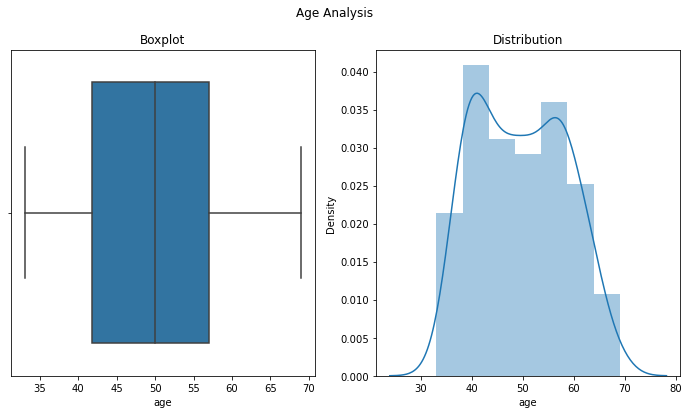

In [41]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
fig.suptitle("Age Analysis")
sns.boxplot(x=samples["age"], ax=axs[0]).set_title('Boxplot')
sns.distplot(samples['age'], ax=axs[1], axlabel='age').set_title('Distribution')

Text(0.5, 1.0, 'Distribution')

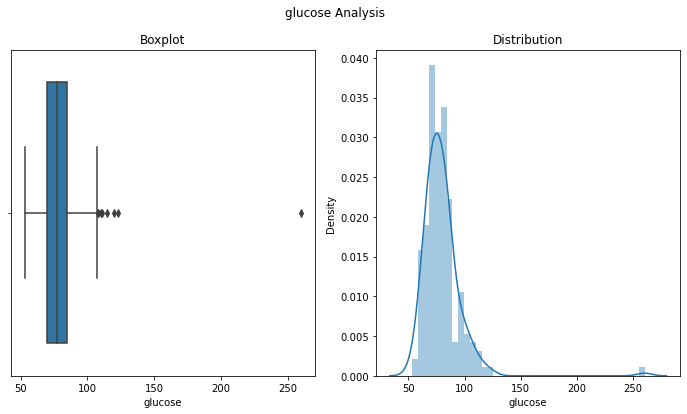

In [42]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
fig.suptitle("glucose Analysis")
sns.boxplot(x=samples["glucose"], ax=axs[0]).set_title('Boxplot')
sns.distplot(samples['glucose'], ax=axs[1], axlabel='glucose').set_title('Distribution')

Text(0.5, 1.0, 'Distribution')

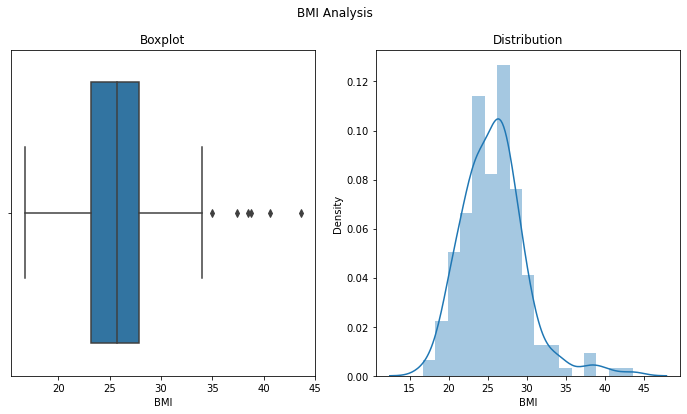

In [43]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
fig.suptitle("BMI Analysis")
sns.boxplot(x=samples["BMI"], ax=axs[0]).set_title('Boxplot')
sns.distplot(samples['BMI'], ax=axs[1], axlabel='BMI').set_title('Distribution')

In [44]:
sex_count = samples.copy()
sex_count.insert(0, 'count', 1)
sex_count = sex_count[['male', 'count']].groupby('male', as_index=False).count()
sex_count

,male,count
0,0,106
1,1,94


### B.

Missing values:

In [45]:
samples.isnull().sum()

glucose    17
age         0
BMI         1
male        0
dtype: int64

**Missing Values**

* As we can see, we have just a few missing values. So we drop these records.
After removing them we are left with:

In [46]:
samples.dropna(inplace=True)
print("Number of records:", samples.shape[0])

Number of records: 183


**Outliers**

* From the boxplots above we see that we have no outliers in regards to glucose and BMI, 

* Regarding sex, we have only male and female.

### C.

Text(0.5, 1.0, 'BMI vs glucose')

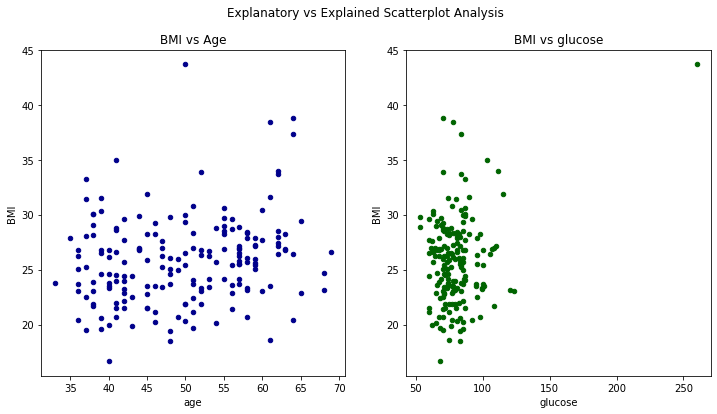

In [47]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
fig.suptitle("Explanatory vs Explained Scatterplot Analysis")
samples.plot.scatter(x='age',
                      y='BMI',
                      c='DarkBlue',ax=axs[0]).set_title("BMI vs Age")
samples.plot.scatter(x='glucose',
                      y='BMI',
                      c='DarkGreen',ax=axs[1]).set_title("BMI vs glucose")


From the scatterplots we can clearly see:

* a strong positive linear correlation between the BMI and the glucose

* No apparent relation between the BMI and the age




### D.

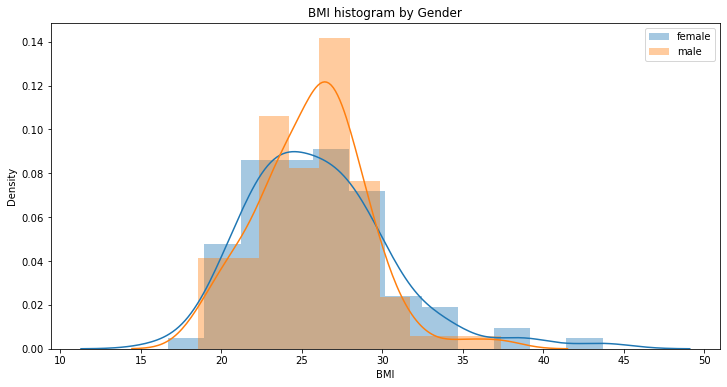

In [48]:
fig, axs = plt.subplots(1,figsize = (12,6))
sns.distplot(samples.loc[samples['male'] == 0]['BMI'], ax=axs, axlabel='BMI', label="female")
sns.distplot(samples.loc[samples['male'] == 1]['BMI'], ax=axs, axlabel='BMI', label="male")
axs.set_title('BMI histogram by Gender')
axs.legend()

## Q4.

Maximum likelihood estimator for the Model:

In [49]:
samples.loc[samples['male'] == '0' , '1'] = 1
samples.loc[samples['male'] == '1' , '0'] = 0
att = ['intercept', "age",'glucose', 'male']
Y = samples["BMI"].to_numpy().reshape((-1,1))
X = samples[["age",'glucose', 'male']]
X['intercept']=1
X= X[att]
X = X.to_numpy(dtype='float64')

results = OLS(Y, X).fit() 

betas = np.array(results.params).reshape((1,-1))
pd.DataFrame(betas, columns=att, index=["Beta Estimator"])

,intercept,age,glucose,male
Beta Estimator,17.314518,0.082715,0.055594,-0.040738


## Q5.

Anova Table:

In [50]:
def create_Anova(results):
  Anova_table = pd.DataFrame([[results.ess, results.df_model, results.mse_model, results.fvalue, results.f_pvalue],
                                [results.ssr, results.df_resid, results.mse_resid],
                                [results.ssr+results.ess, results.df_model+results.df_resid]],
                               index=['Reg','Res', 'Total'], columns=['SS','df', 'MS', 'F', 'Pvalue']).fillna("")
  return Anova_table

create_Anova(results)

,SS,df,MS,F,Pvalue
Reg,307.772789,3.0,102.591,7.21017,0.000135202
Res,2546.926704,179.0,14.2286,,
Total,2854.699493,182.0,,,


$R^2:$

In [51]:
results.rsquared

0.10781267509570602

$R_{adj}^2$:

In [52]:
results.rsquared_adj

0.09285981490177941

A pretty strong correlation!

## Q6.

Confidence intervals for $\beta_{\mbox{sex}}^*, \ \beta_{\mbox{height}}^*, \ \beta_{\mbox{age}}^*$:

In [53]:

conf_int = pd.DataFrame(results.conf_int()[1:])
conf_int.columns = ['Lower','Upper']
conf_int.rename(index={0:'Age',1:'glucose', 2:'male'}, inplace=True)
conf_int

,Lower,Upper
Age,0.019632,0.145799
glucose,0.025457,0.085730
male,-1.150242,1.068765


In [54]:

att = ['intercept', "age",'glucose', 'male']
input_data = df.copy()
input_data = input_data[["age",'glucose', 'male', "BMI"]]

input_data.loc[input_data['male'] == '0' , 'male'] = 1
input_data.loc[input_data['male'] == '1' , 'male'] = 0

input_data.dropna(inplace=True)

Y_full = input_data["BMI"].to_numpy().reshape((-1,1))
X_full = input_data[["age",'glucose', 'male']]

X_full['intercept']=1
X_full= X_full[att]
X_full = X_full.to_numpy(dtype='float64')

results_full = OLS(Y_full, X_full).fit() 

betas = np.array(results_full.params).reshape((1,-1))
pd.DataFrame(betas, columns=att, index=["Beta Estimator"])

,intercept,age,glucose,male
Beta Estimator,21.470093,0.061444,0.012254,0.646858


In [55]:
z=results.wald_test_terms()
z = z.table[1:]
z.rename(index={'x1':'Age','x2':'Glucose', 'x3':'Male'}, inplace=True)
z[['statistic','pvalue']]

,statistic,pvalue
Age,6.694643,0.010464
Glucose,13.250967,0.000356
Male,0.005250,0.942321


## Q8.

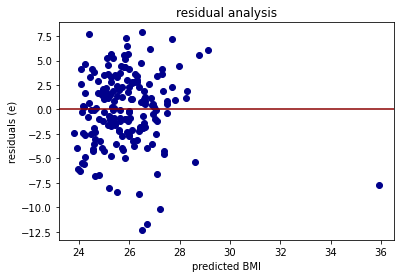

In [56]:
prediction = results.get_prediction(X)
prediction = prediction.predicted_mean.reshape((-1,1))
plt.scatter(prediction,prediction-Y, color='DarkBlue')
plt.title("residual analysis")
plt.xlabel("predicted BMI")
plt.ylabel("residuals (e)")
plt.axhline(color='DarkRed')
# plt.ylim(-25,25)
plt.show()

## Q9.

In [57]:
full_samples = input_data.copy()
full_samples.drop(samples.index, inplace=True)
bigger_samples = full_samples.sample(1000, random_state=0)

bigger_samples_Y = bigger_samples['BMI']
bigger_samples

,age,glucose,male,BMI
2201,45,75.0,1,32.03
656,51,74.0,1,29.86
1563,54,75.0,0,29.40
3684,38,70.0,1,28.30
1992,40,123.0,0,27.46
...,...,...,...,...
3139,40,73.0,0,35.02
979,64,80.0,0,20.67
3341,59,89.0,0,21.82
2334,40,74.0,0,31.77


### A. 

Predicting $\hat{Y}$ for all the new points.

In [58]:
bigger_samples['intercept']=1
bigger_samples_array = bigger_samples[att].to_numpy(dtype='float64').reshape((-1,4)) # reorder columns and drop bmi
Y_pred = results.predict(bigger_samples_array)

### B.

Calculating the CIs

In [59]:
def get_ci(results_model,X_new, X):
    C = np.linalg.inv(np.matmul(X.T, X)) 
    prediction = results_model.get_prediction(X_new).predicted_mean.reshape((-1,1))
    n, p = X.shape
    sigma_hat = results_model.ssr/(n-p)
    s_e_hat_2 = (np.matmul(np.matmul(X_new.T,C),X_new))*sigma_hat
    temp_res = 1.96*sqrt(s_e_hat_2+sigma_hat)
#     print(f"CI for the prediction is {prediction-temp_res},{prediction+temp_res}")
    return (prediction-temp_res)[0][0], (prediction+temp_res)[0][0]

CIs = np.zeros((1000,2))
for i in range(1000):    
    CIs[i] = get_ci(results,bigger_samples_array[i], X)
    


### C.

In [60]:
Y_real = bigger_samples_Y.to_numpy()
sums=0
CIs_len = np.zeros((1000,1))
for i in range(1000):
    if (Y_real[i] >= CIs[i][0] and Y_real[i] <= CIs[i][1]):
        sums+=1
        
    CIs_len[i] =  CIs[i][1] - CIs[i][0] #len CI

print("Number of CIs that contain Y_new:",sums)

Number of CIs that contain Y_new: 950


Distribution of CI lengths:

<AxesSubplot:xlabel='CI length', ylabel='Density'>

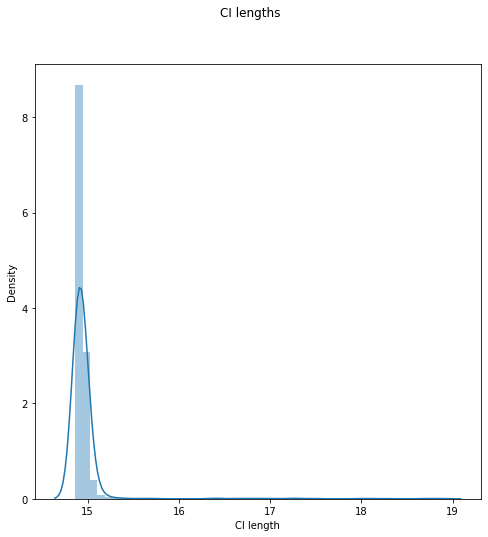

In [61]:
#distribution of lenght of CI's for every size sample
fig, axs = plt.subplots(1,1,figsize = (8,8))
fig.suptitle("CI lengths")
sns.distplot(CIs_len, ax=axs, axlabel='CI length')

Summary statistics for the CIs:

In [62]:
pd.DataFrame(CIs_len).describe()

,0
count,1000.000000
mean,14.961706
std,0.298400
min,14.866167
25%,14.887948
50%,14.916144
75%,14.957097
max,18.863872


## Q10.



In [63]:
X_12 = (X[:,1]*X[:,2]).reshape((-1,1))
X_13 = (X[:,1]*X[:,3]).reshape((-1,1))
X_23 = (X[:,2]*X[:,3]).reshape((-1,1))
interaction_X = np.c_[X, X_12, X_13, X_23]
results_interaction = OLS(Y, interaction_X).fit() 

betas = np.array(results_interaction.params).reshape((1,-1))
pd.DataFrame(betas, columns=att+['age-height','age-sex','height-sex'], index=["Beta Estimator"])

,intercept,age,glucose,male,age-height,age-sex,height-sex
Beta Estimator,8.132101,0.271151,0.127824,6.029758,-0.001502,-0.139847,0.010697


We chose to look at three measures - $R^2_{adj}, \ BIC, \ AIC$ to evaluate the two models.

As we compared models with a different amount of paramaters (one model has interaction parameters and one doesn't) we selected measures that punish models with more parameters.

In [64]:
pd.DataFrame([[results_interaction.rsquared_adj, results.rsquared_adj],
            [-results_interaction.bic/2, -results.bic/2],
            [-results_interaction.aic/2, -results.aic/2]], index=["rsquared_adj","BIC","AIC"],columns=["With Interaction", "Without Interaction"])


,With Interaction,Without Interaction
rsquared_adj,0.103754,0.092860
BIC,-516.180767,-511.018548
AIC,-504.947566,-504.599575






From the table we can see that the measures are pretty similar when comparing both models. Specifically when looking at $R^2_{adj}$ the model with interaction is slightly better and when looking at $BIC \ \& \ AIC$ the model without interaction is slightly better.

* Higher is better for these measures

# Part 2

The selected explanatory parameters:

* Male - Binary (Male / Female)

* Age - Numeric

* BMI - Numeric

The selected explained parameter:

* diabetes - Binary (has / hasn't) 


## Q1.

Test question:

**Does the age, sex and BMI influence the chance to diabetes?
**

## Q2.

In [65]:
# Sample the data
samples2 = df[["age", "BMI", "male", 'diabetes']].sample(200, random_state=0)
samples2

,age,BMI,male,diabetes
1669,47,27.64,0,0
156,58,23.36,0,0
87,61,38.46,0,0
685,45,25.92,0,0
666,57,26.24,0,0
...,...,...,...,...
1185,46,23.48,1,0
3905,44,26.97,1,0
3382,61,31.63,0,0
465,38,30.02,1,0


## Q3.

We use the variables - Age, Sex and BMI.

In addition we added 'diabetes' - boolean variable indicating whether the person has diabetes or not.


### A.

In [66]:
sex_count = samples2.copy()
sex_count.insert(0, 'count', 1)
sex_count = sex_count[['diabetes', 'count']].groupby('diabetes', as_index=False).count()
sex_count

,diabetes,count
0,0,198
1,1,2


### B.

Missing Values:

In [67]:
samples2.isnull().sum()

age         0
BMI         1
male        0
diabetes    0
dtype: int64

**Missing Values**

* As we can see, we have just a few missing values (same as before). So we drop these records. After removing them we are left with:

In [68]:
samples2.dropna(inplace=True)
print("Number of records:", samples2.shape[0])

Number of records: 199


**Outliers**

* Regarding diabetes, we have only sick or healthy, so outliers isn't relevant.

**Distribution**:
    
* Only 1 of the sampled people has no diabetes so the distribution is **not** symmetric.   
   

### C.

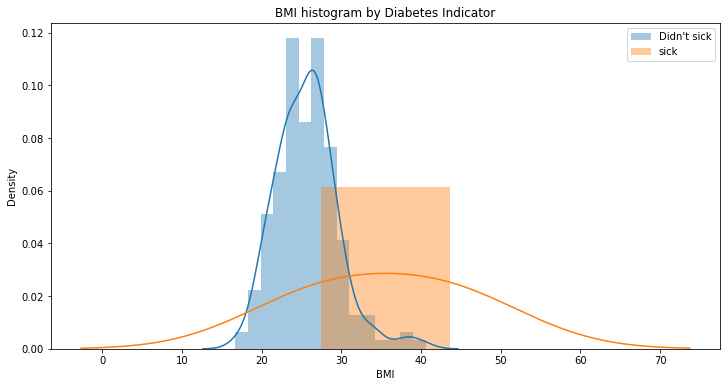

In [69]:
fig, axs = plt.subplots(1,figsize = (12,6))
sns.distplot(samples2.loc[samples2['diabetes'] == False]['BMI'], ax=axs, axlabel='BMI', label="Didn't sick")
sns.distplot(samples2.loc[samples2['diabetes'] == True]['BMI'], ax=axs, axlabel='BMI', label="sick")
axs.set_title('BMI histogram by Diabetes Indicator')
axs.legend()

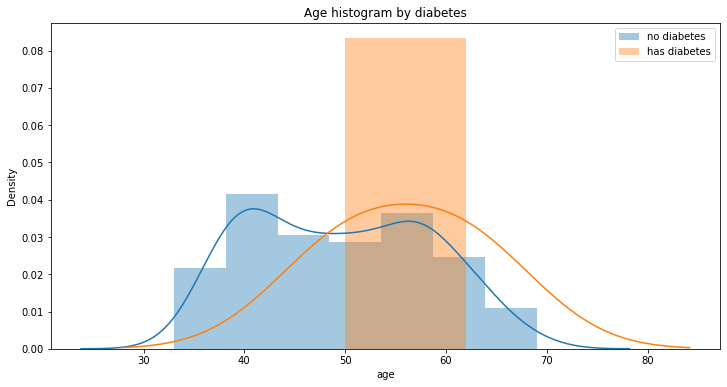

In [70]:
fig, axs = plt.subplots(1,figsize = (12,6))

sns.distplot(samples2.loc[samples2['diabetes'] == False]['age'], ax=axs, axlabel='age', label="no diabetes")
sns.distplot(samples2.loc[samples2['diabetes'] == True]['age'], ax=axs, axlabel='age', label="has diabetes")
axs.set_title('Age histogram by diabetes')
axs.legend()

From the above histograms, it seems that 

age is the strongest indicator 

of has diabetes (out of our continous variables).

This is because the distribution of has/hasnt diabetes is very similar when looking at age.

## Q4.

Estimator for the regression diabetes:


In [71]:

samples2.loc[samples2['male'] == 'female' , 'male'] = 1
samples2.loc[samples2['male'] == 'male' , 'male'] = 0
att = ['intercept', "age", 'male', 'BMI']
Y2 = samples2["diabetes"].to_numpy(dtype='float64').reshape((-1,1))
X2 = samples2[["age", 'male', 'BMI']]
X2['intercept']=1
X2= X2[att]
X2 = X2.to_numpy(dtype='float64')

results2 = Logit(Y2, X2).fit(disp=False)

betas = np.array(results2.params).reshape((1,-1))
pd.DataFrame(betas, columns=att, index=["Beta Estimator"])

,intercept,age,male,BMI
Beta Estimator,-15.213726,0.062167,-21.562862,0.264666


Generally, for each attribute $i$ in the diabetes the meaning of $\hat{\beta_i}$ is that increasing of one unit in this attribute multiplies the odds ratio with $e^\hat{\beta_i}$

* We got that increasing age by one year multiplies the odds ratio with $\approx$ 0.062 - a small increase in the chance to get sick in diabeetes.

* We got that for each increase of BMI by one multiplies the odds ratio with $\approx$ 0.2646 - a small decrease in the chance to get diabetes.

* We got that being a female (compared to male) multiplies the odds ratio with $\approx$ -21.56 - a big increase in the chance to get diabetes

## Q5.

Confidence intervals for $\beta_{\mbox{sex}}^*, \ \beta_{\mbox{BMI}}^*, \ \beta_{\mbox{age}}^*$:

In [72]:
conf_int = pd.DataFrame(results2.conf_int()[1:])
conf_int.columns = ['Lower','Upper']
conf_int.rename(index={0:'Age',1:'male', 2:'BMI'}, inplace=True)
conf_int

,Lower,Upper
Age,-0.164993,0.289327
male,-99656.180185,99613.054461
BMI,0.029200,0.500131


The actual $\beta_{\mbox{sex}}^*, \ \beta_{\mbox{BMI}}^*, \ \beta_{\mbox{age}}^*$ (based on the full data):

In [73]:

att = ['intercept', "age",'male', 'BMI']
input_data2 = df.copy()
input_data2 = input_data2[["age",'male', 'BMI', 'diabetes']]

input_data2.loc[input_data2['male'] == 'female' , 'male'] = 1
input_data2.loc[input_data2['male'] == 'male' , 'male'] = 0

input_data2.dropna(inplace=True)

Y_full2 = input_data2["diabetes"].to_numpy(dtype='float64').reshape((-1,1))
X_full2= input_data2[[ "age",'male', 'BMI']]

X_full2['intercept']=1
X_full2= X_full2[att]
X_full2 = X_full2.to_numpy(dtype='float64')

results_full2 = Logit(Y_full2, X_full2).fit(disp=False) 

betas = np.array(results_full2.params).reshape((1,-1))
pd.DataFrame(betas, columns=att, index=["Beta Estimator"])

,intercept,age,male,BMI
Beta Estimator,-9.989777,0.070156,0.278884,0.095168


We can see that for all our explanatory variables - $i \in \{age, bmi, sex\}$, it holds that  $\beta_{\mbox{i}}^* \in CI_{\hat{\beta_{\mbox{i}}}}$

So the CI's for the estimator, based on the sample data, include the real paramaters :) 


## Q6.

Beta estimators for Model that has interactions age-sex,	age-bmi and	sex-bmi in addition to age,	bmi and sex.

In [74]:
X2_12 = (X2[:,1]*X2[:,2]).reshape((-1,1))
X2_13 = (X2[:,1]*X2[:,3]).reshape((-1,1))
X2_23 = (X2[:,2]*X2[:,3]).reshape((-1,1))
interaction_X2 = np.c_[X2, X2_12, X2_13, X2_23]
results_interaction2 = Logit(Y2, interaction_X2).fit(disp=False) 

betas = np.array(results_interaction2.params).reshape((1,-1))
pd.DataFrame(betas, columns=att+['age-male','age-BMI','male-BMI'], index=["Beta Estimator"])

,intercept,age,male,BMI,age-male,age-BMI,male-BMI
Beta Estimator,-92.957876,1.422725,40.291578,2.550196,-0.752596,-0.04041,-1.172406


We chose to look at two measures - $BIC, \& \ AIC$ to evaluate the two models.

As we compared models with a different amount of paramaters (one model has interaction parameters and one doesn't) we selected measures that punish models with more parameters.

In [75]:
pd.DataFrame([[-results_interaction2.bic/2, -results2.bic/2],
            [-results_interaction2.aic/2, -results2.aic/2]], index=["BIC","AIC"],columns=["With Interaction", "Without Interaction"])

,With Interaction,Without Interaction
BIC,-23.581353,-17.454687
AIC,-12.054786,-10.868077


From the table we can see that the measures are pretty similar when comparing both models. 

By both measures we conclude that the model without interaction is slightly better.

* Higher is better for these measures